In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [ ]:
# Step 1: Mount Google Drive to access the saved model
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Load the previously trained model

loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/SRM_DeepLearning/mobilenetv2_beans_model.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#  Load the Citrus Leaves dataset
ds_train_full, ds_info = tfds.load(
    'citrus_leaves',
    split='train',
    as_supervised=True,
    with_info=True
)

# Step 2: Split the dataset into training and testing sets
# Use 80% for training and 20% for testing
train_size = 0.8
ds_train = ds_train_full.take(int(train_size * ds_info.splits['train'].num_examples))
ds_test = ds_train_full.skip(int(train_size * ds_info.splits['train'].num_examples))

# Step 4: Preprocess the Citrus Leaves data
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1] range
    return image, label

ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



# Get the class names for Citrus Leaves dataset
class_names = ds_info.features['label'].names

In [ ]:
# Step 5: Modify the output layer to match the Citrus Leaves classes
# Make the base model trainable for fine-tuning
loaded_model.trainable = True

# # # Freeze all the layers in the original model
# for layer in loaded_model.layers:
#     layer.trainable = False

# Add a new output layer with a unique name
# x = loaded_model.layers[-2].output
# output = Dense(len(class_names), activation='softmax', name='new_dense_output')(x)

# Replace the output layer with a new one for the Citrus Leaves dataset
x = loaded_model.layers[-2].output  # Get the second last layer
output = Dense(len(class_names), activation='softmax',name='new_dense_output')(x)
new_model = Model(inputs=loaded_model.input, outputs=output)

# Step 6: Compile the new model
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 7: Apply early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 8: Train the new model on the Citrus Leaves dataset
history = new_model.fit(ds_train, validation_data=ds_test, epochs=50, callbacks=[early_stopping])

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4078 - loss: 1.5570 - val_accuracy: 0.7143 - val_loss: 0.6950
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7802 - loss: 0.5530 - val_accuracy: 0.7731 - val_loss: 0.5314
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8565 - loss: 0.3991 - val_accuracy: 0.8151 - val_loss: 0.4671
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8831 - loss: 0.3029 - val_accuracy: 0.8403 - val_loss: 0.4470
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9196 - loss: 0.2481 - val_accuracy: 0.8403 - val_loss: 0.4485
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9283 - loss: 0.2336 - val_accuracy: 0.8235 - val_loss: 0.4502
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9331 - loss: 0.2194 - val_accuracy: 0.8403 - val_loss: 0.4036
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9287 - loss: 0.2033 - val_accuracy: 0.8571 - va

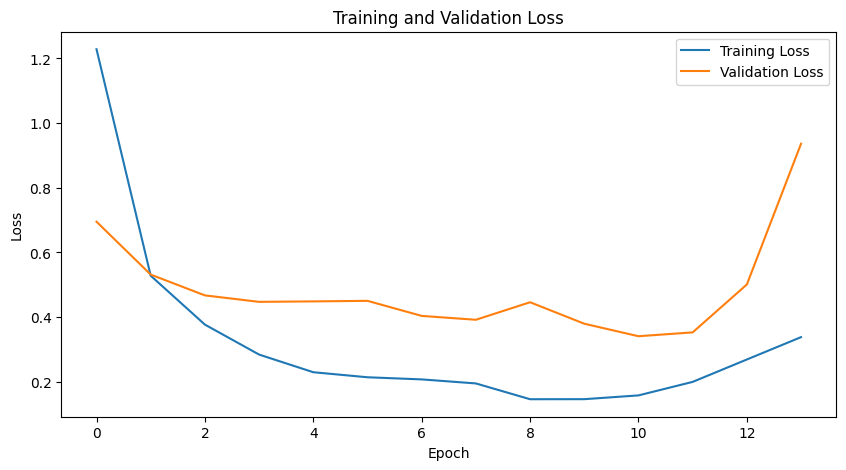

In [ ]:
# Step 9: Plot the training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


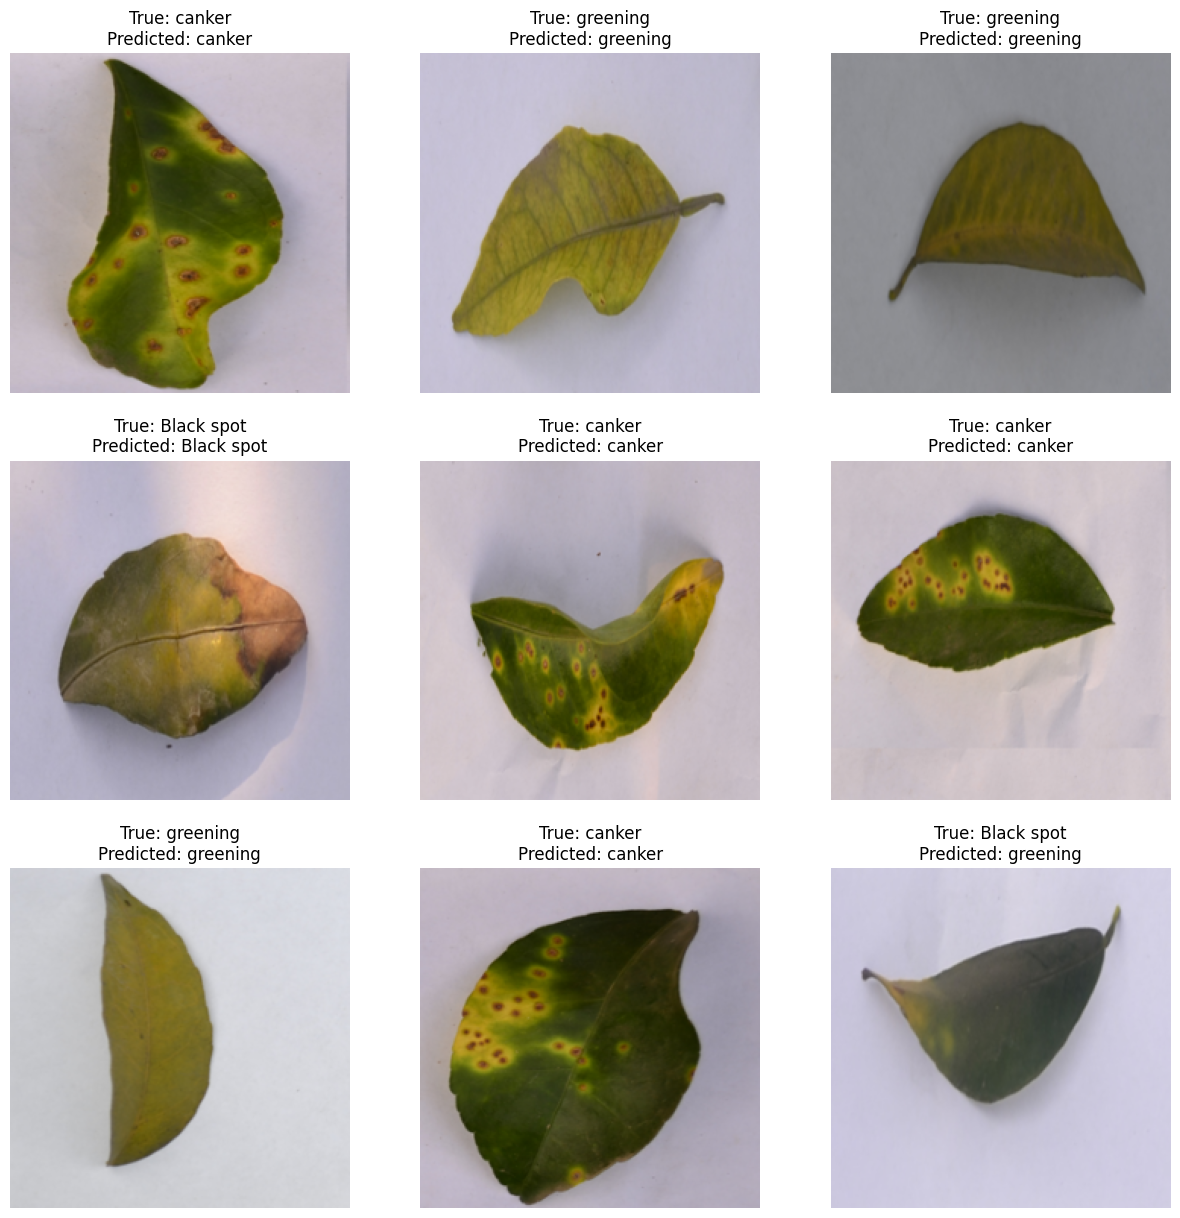

In [ ]:

# Step 10: Predict on the test data and visualize the results
test_images, test_labels = next(iter(ds_test))
predictions = new_model.predict(test_images)

plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy())
    predicted_label = class_names[tf.argmax(predictions[i])]
    true_label = class_names[test_labels[i].numpy()]
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis("off")
plt.show()